# ***DATA LOADING & PRE-PROCESSING***

In [ ]:
import pandas as pnd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Paths :

UT_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_05_UT.csv"
RJ_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_08_RJ.csv"
UP_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_09_UP.csv"
BH_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_10_BH.csv"
AS_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_18_AS.csv"
JH_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_20_JH.csv"
OR_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_21_OR.csv"
CT_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_22_CT.csv"
MP_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/CAB_23_MP.csv"

pickled_path = "/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/merged"



In [ ]:
#loading the files : (, encoding="cp1252")
merged_df = pnd.concat(map(pnd.read_csv, [UT_path, RJ_path, UP_path, BH_path, AS_path, JH_path, OR_path, CT_path, MP_path]), ignore_index=True)

#replacing all the missing values represemted as -1 with actual missing values :
merged_df = merged_df.replace([-1, '-1'], np.nan)


In [ ]:
# Information Before Preprocessing the Dataframes (UP)
merged_df.describe()

In [ ]:
# Reusable Functions 

def serialize(path,data):
  pick = open(path, 'ab')
  pk.dump(data, pick)                     
  pick.close()

def deserialize(path):
  pick = open(path, 'rb')     
  df = pk.load(pick)
  pick.close()
  return df

def label_encode(data, cols):
  for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))
  return data

def count_nas(df):
  lst = pnd.DataFrame(columns = ['Column_Name', 'Count_of_missing_values']) 
  cols = df.columns
  for i in cols:
    lst.loc[len(lst.index)] = [i, df[i].isna().sum()]
  return lst


In [ ]:
#Features to be considered : 

features_selected = ["state_code","test_salt_iodine", "sex", "age_code", "age", "weight_in_kg", "length_height_cm", "haemoglobin_level", "bp_systolic","bp_systolic_2_reading","bp_diastolic","bp_diastolic_2reading","pulse_rate","pulse_rate_2_reading","fasting_blood_glucose_mg_dl"]


In [ ]:
# Retaining only required features : 

merged_df = merged_df.loc[:,features_selected]
merged_df = merged_df.dropna()


In [ ]:
# Preprocessing the finalized data : 

def to_years(df):
  df.loc[df['age_code']=='y'] = 'Y'
  df.loc[df['age_code']=='D']['age'] = df.loc[df['age_code']=='D']['age']/365
  df.loc[df['age_code']=='M']['age'] = df.loc[df['age_code']=='M']['age']/12
  return df

def averages(df):
  df['systolic'] = (df['bp_systolic'] + df['bp_systolic_2_reading'])
  df.drop(df.index[df['systolic'] == 'YY'], inplace=True)
  df['systolic'] = df['systolic'].astype(int)
  df['systolic'] = df['systolic'] / 2

  df['diastolic'] = (df['bp_diastolic'] + df['bp_diastolic_2reading'])
  df.drop(df.index[df['diastolic'] == 'YY'], inplace=True)
  df['diastolic'] = df['diastolic'].astype(int)
  df['diastolic'] = df['diastolic'] / 2

  df['pulse'] = (df['pulse_rate'] + df['pulse_rate_2_reading'])
  df.drop(df.index[df['pulse'] == 'YY'], inplace=True)
  df['pulse'] = df['pulse'].astype(int)
  df['pulse'] = df['pulse'] / 2
  
  return df

def to_Binary(df):
  df['sex'] = df['sex'].astype(int)
  df['sex'] = df['sex'] - 1
  return df

def round_off(df):
  df['test_salt_iodine'] = df['test_salt_iodine'].astype(int)
  df['weight_in_kg'] = df['weight_in_kg'].astype(float).round(decimals = 1)
  df['length_height_cm'] = df['length_height_cm'].astype(float).round(decimals = 1)
  return df

def feature_engineer(df):
  df['response'] = np.where(df['fasting_blood_glucose_mg_dl'] > 125,1,0)
  return df

def remove_outliers(df):
  # calculates z-score values
  df["zscore"] = zscore(df["weight_in_kg"]) 
  df["is_outlier"] = df["zscore"].apply(lambda x: x <= -1.96 or x >= 1.96)
  df = df[df['is_outlier'] == False]
  
  df["zscore"] = zscore(df["length_height_cm"]) 
  df["is_outlier"] = df["zscore"].apply(lambda x: x <= -1.96 or x >= 1.96)
  df = df[df['is_outlier'] == False]

  df.drop("zscore", axis=1, inplace=True)
  df.drop("is_outlier", axis=1, inplace=True)
  return df



 

merged_df = to_years(merged_df)
merged_df = averages(merged_df)
merged_df = to_Binary(merged_df)
merged_df = round_off(merged_df)
merged_df = feature_engineer(merged_df)
merged_df = remove_outliers(merged_df)



In [ ]:
# Serializing the preprocessed data, to be used for training the agents : 

serialize(pickled_path, merged_df)
DF = deserialize(pickled_path)
DF = DF.to_numpy()


In [ ]:
# Whole dataset as a pandas Dataframe :
merged_df

In [ ]:
# Proportion of Diabetic vs No-Diabetic class in the whole dataset
merged_df['response'].value_counts()


In [ ]:
# Whole dataset as a numpy array (specifically for training the neural network agents)
DF

# ***DATA VISUALIZATION***

## DF

In [ ]:
# merged_df - features selected and preprocessed dataset (Pandas dataframe format)
# DF - deserialized object from the the pickled file (numpy array format)

plt.style.use('classic')
plt.rcParams['agg.path.chunksize'] = 10000
colors = ['#0000FF', '#00FF00', '#FFFF00', '#FF00FF']

### HEATMAP

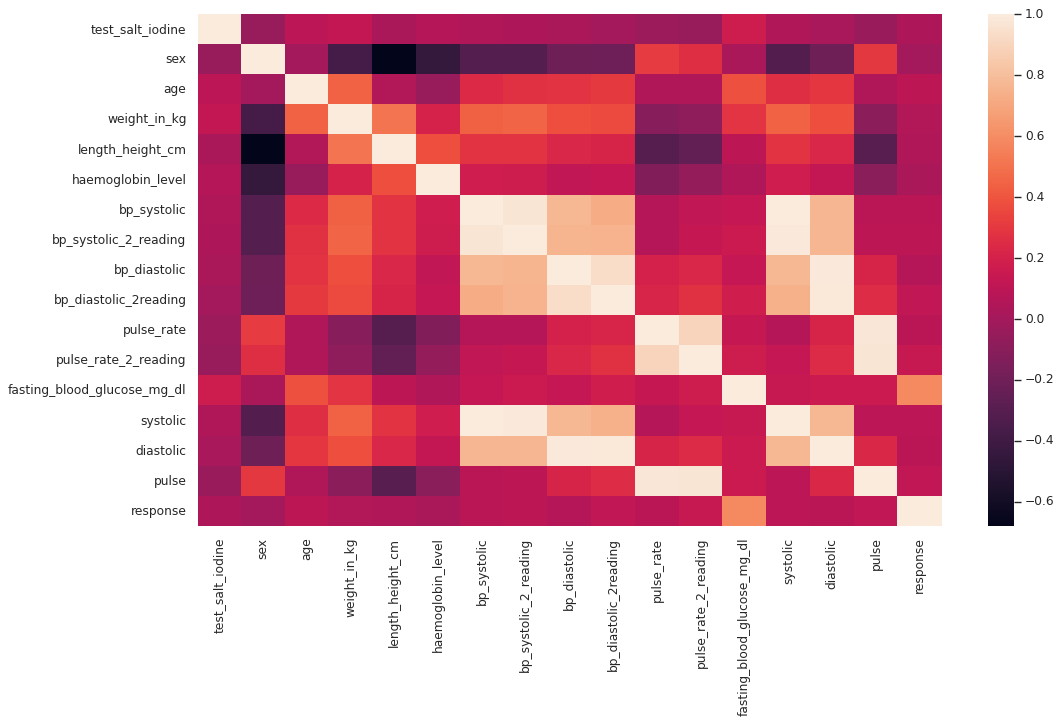

In [ ]:
merged_df['age'] = merged_df['age'].astype(float)
merged_df['haemoglobin_level'] = merged_df['haemoglobin_level'].astype(float)
merged_df['bp_systolic'] = merged_df['bp_systolic'].astype(float)
merged_df['bp_systolic_2_reading'] = merged_df['bp_systolic_2_reading'].astype(float)
merged_df['bp_diastolic'] = merged_df['bp_diastolic'].astype(float)
merged_df['bp_diastolic_2reading'] = merged_df['bp_diastolic_2reading'].astype(float)
merged_df['pulse_rate'] = merged_df['pulse_rate'].astype(float)
merged_df['pulse_rate_2_reading'] = merged_df['pulse_rate_2_reading'].astype(float)
merged_df['fasting_blood_glucose_mg_dl'] = merged_df['fasting_blood_glucose_mg_dl'].astype(float)
# merged_df = merged_df.drop(['age_code'], axis=1)


sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.heatmap(merged_df.loc[:1000,:].corr())

### *Plots evincing readings contrasted withs its corresponding feature engineered values.*

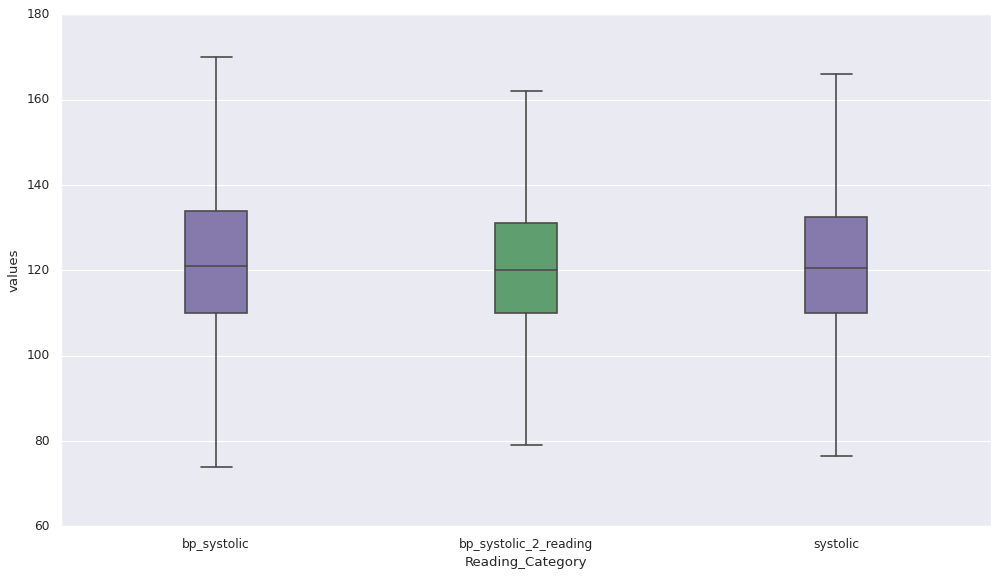

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})

temp1 = pnd.DataFrame()
temp1['values'] = merged_df['bp_systolic']
temp1['Reading_Category'] = 'bp_systolic'

temp2 = pnd.DataFrame()
temp2['values'] = merged_df['bp_systolic_2_reading']
temp2['Reading_Category'] = 'bp_systolic_2_reading'

temp3 = pnd.DataFrame()
temp3['values'] = merged_df['systolic']
temp3['Reading_Category'] = 'systolic'

temp = pnd.concat([temp1, temp2, temp3], ignore_index=True)

sb.boxplot(x = 'Reading_Category', y = 'values', palette=["m", "g"], data = temp, showfliers=False, width = 0.2)


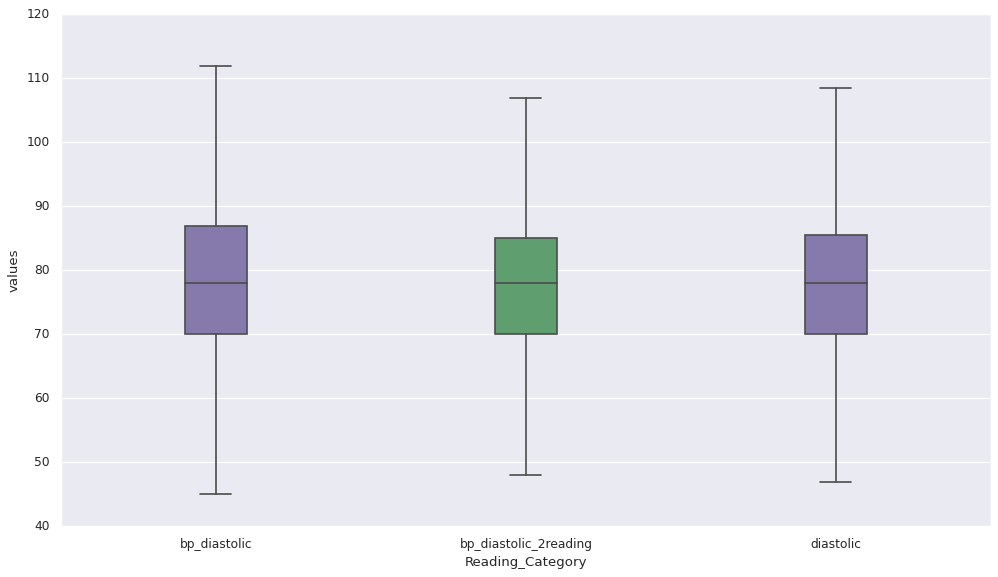

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})

temp1 = pnd.DataFrame()
temp1['values'] = merged_df['bp_diastolic']
temp1['Reading_Category'] = 'bp_diastolic'

temp2 = pnd.DataFrame()
temp2['values'] = merged_df['bp_diastolic_2reading']
temp2['Reading_Category'] = 'bp_diastolic_2reading'

temp3 = pnd.DataFrame()
temp3['values'] = merged_df['diastolic']
temp3['Reading_Category'] = 'diastolic'

temp = pnd.concat([temp1, temp2, temp3], ignore_index=True)

sb.boxplot(x = 'Reading_Category', y = 'values', palette=["m", "g"], data = temp, showfliers=False, width = 0.2)


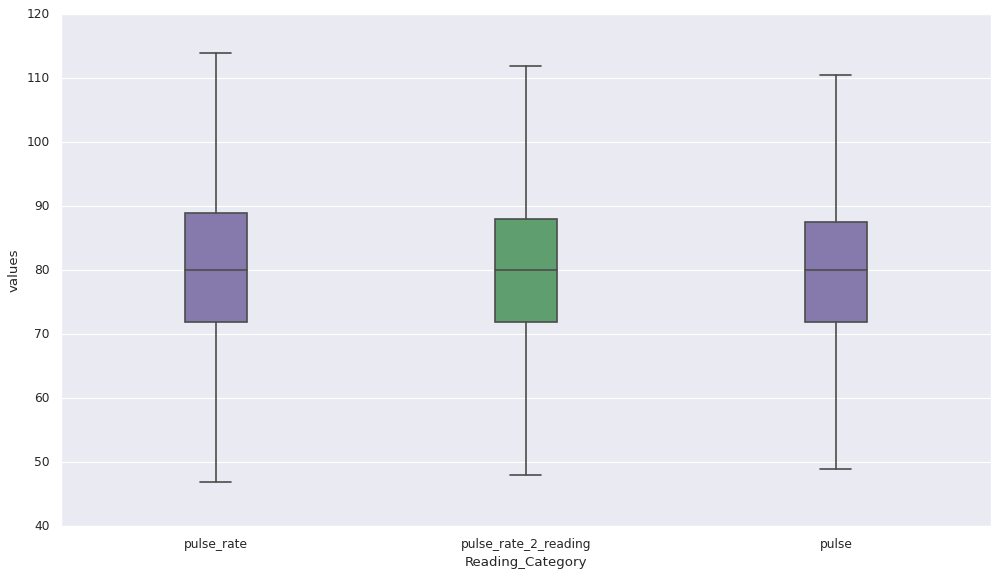

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})

temp1 = pnd.DataFrame()
temp1['values'] = merged_df['pulse_rate']
temp1['Reading_Category'] = 'pulse_rate'

temp2 = pnd.DataFrame()
temp2['values'] = merged_df['pulse_rate_2_reading']
temp2['Reading_Category'] = 'pulse_rate_2_reading'

temp3 = pnd.DataFrame()
temp3['values'] = merged_df['pulse']
temp3['Reading_Category'] = 'pulse'

temp = pnd.concat([temp1, temp2, temp3], ignore_index=True)

sb.boxplot(x = 'Reading_Category', y = 'values', palette=["m", "g"], data = temp, showfliers=False, width = 0.2)


### *Plots to check the role of gender influencing systolic, diastolic, pulse or fasting glucose readings.*

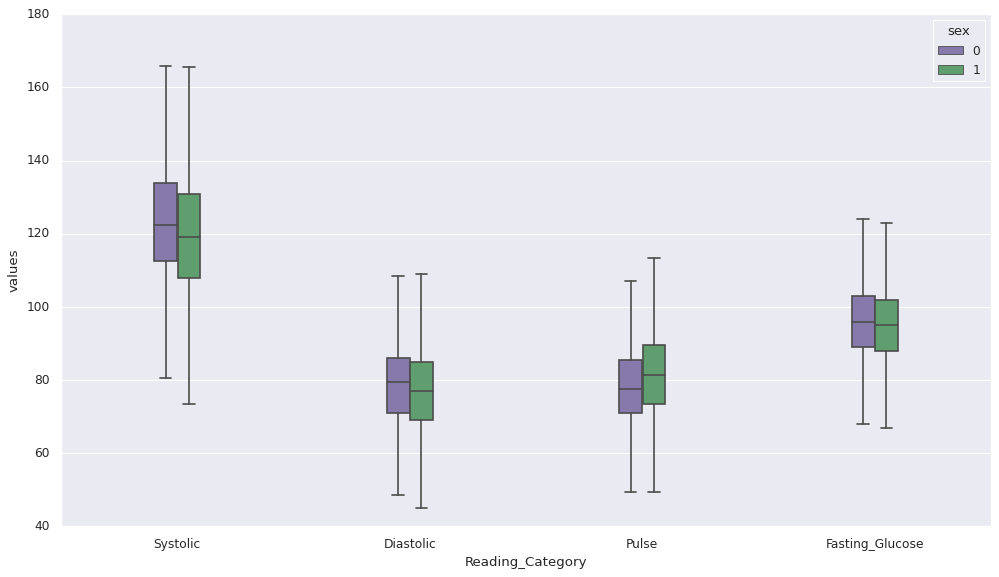

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})

temp1 = pnd.DataFrame()
temp1['sex'] = merged_df['sex']
temp1['values'] = merged_df['systolic']
temp1['Reading_Category'] = 'Systolic'

temp2 = pnd.DataFrame()
temp2['sex'] = merged_df['sex']
temp2['values'] = merged_df['diastolic']
temp2['Reading_Category'] = 'Diastolic'

temp3 = pnd.DataFrame()
temp3['sex'] = merged_df['sex']
temp3['values'] = merged_df['pulse']
temp3['Reading_Category'] = 'Pulse'

temp4 = pnd.DataFrame()
temp4['sex'] = merged_df['sex']
temp4['values'] = merged_df['fasting_blood_glucose_mg_dl']
temp4['Reading_Category'] = 'Fasting_Glucose'

temp = pnd.concat([temp1, temp2, temp3,temp4], ignore_index=True)

sb.boxplot(x = 'Reading_Category', hue = 'sex', y = 'values', palette=["m", "g"], data = temp, showfliers=False, width = 0.2)


### *Density Plot of features that contribute the most information indicating a patient being diabetic or non-diabetic.*

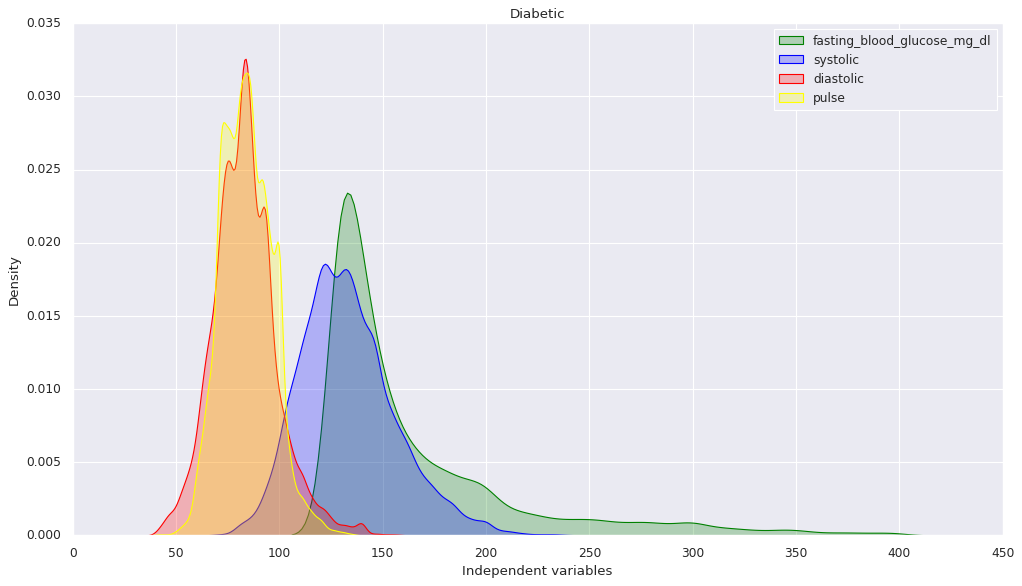

In [ ]:
# for diabetic patients
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(merged_df['fasting_blood_glucose_mg_dl'].loc[merged_df['response']==1], color="green", shade=True,label = 'fasting_blood_glucose_mg_dl')
sb.kdeplot(merged_df['systolic'].loc[merged_df['response']==1], color="blue", shade=True,label = 'systolic')
sb.kdeplot(merged_df['diastolic'].loc[merged_df['response']==1], color="red", shade=True,label = 'diastolic')
sb.kdeplot(merged_df['pulse'].loc[merged_df['response']==1], color="yellow", shade=True,label = 'pulse')
plt.title('Diabetic')
plt.xlabel('Independent variables')
plt.legend()

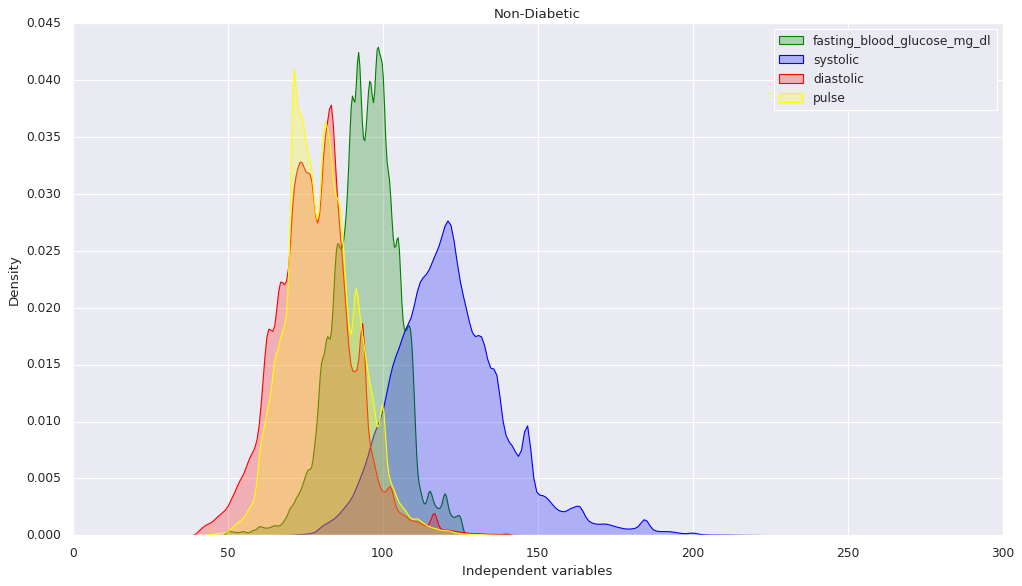

In [ ]:
# for diabetic patients
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(merged_df['fasting_blood_glucose_mg_dl'].loc[merged_df['response']==0], color="green", shade=True,label = 'fasting_blood_glucose_mg_dl')
sb.kdeplot(merged_df['systolic'].loc[merged_df['response']==0], color="blue", shade=True,label = 'systolic')
sb.kdeplot(merged_df['diastolic'].loc[merged_df['response']==0], color="red", shade=True,label = 'diastolic')
sb.kdeplot(merged_df['pulse'].loc[merged_df['response']==0], color="yellow", shade=True,label = 'pulse')
plt.xlabel('Independent variables')
plt.title('Non-Diabetic')
plt.legend()

### *Plots showing the influence of Weight and Height to a particular patient being diabetic or non-diabetic.*

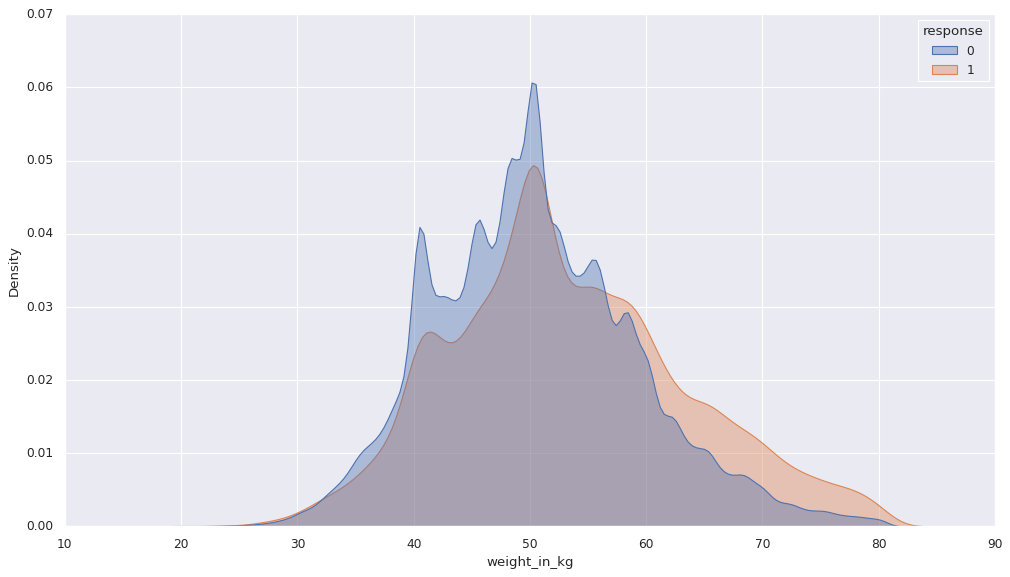

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(data=merged_df, x="weight_in_kg", hue="response", shade = True, common_norm=False, alpha=0.4)


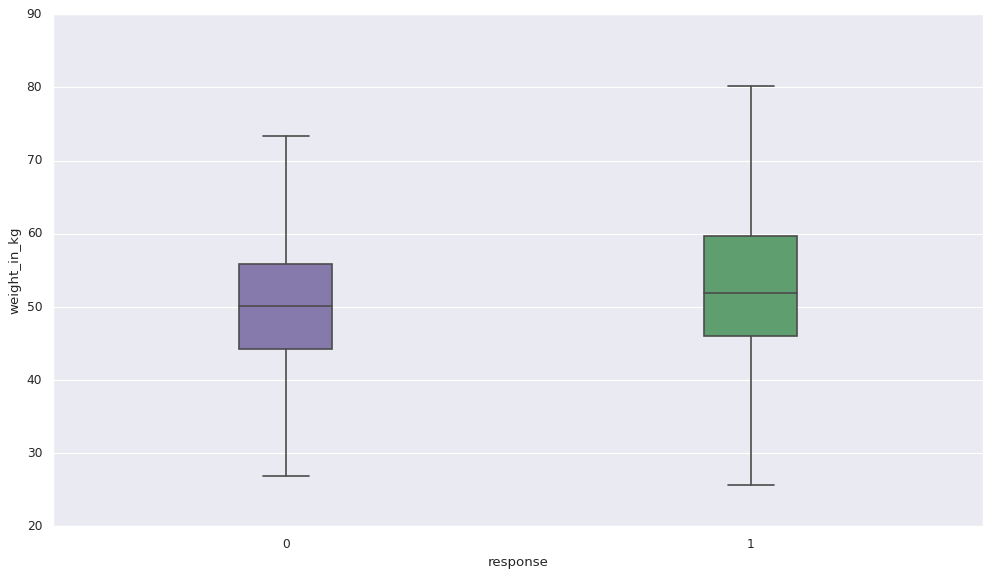

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.boxplot(data=merged_df, x="response",y= 'weight_in_kg',showfliers=False, width = 0.2,palette=["m", "g"],)


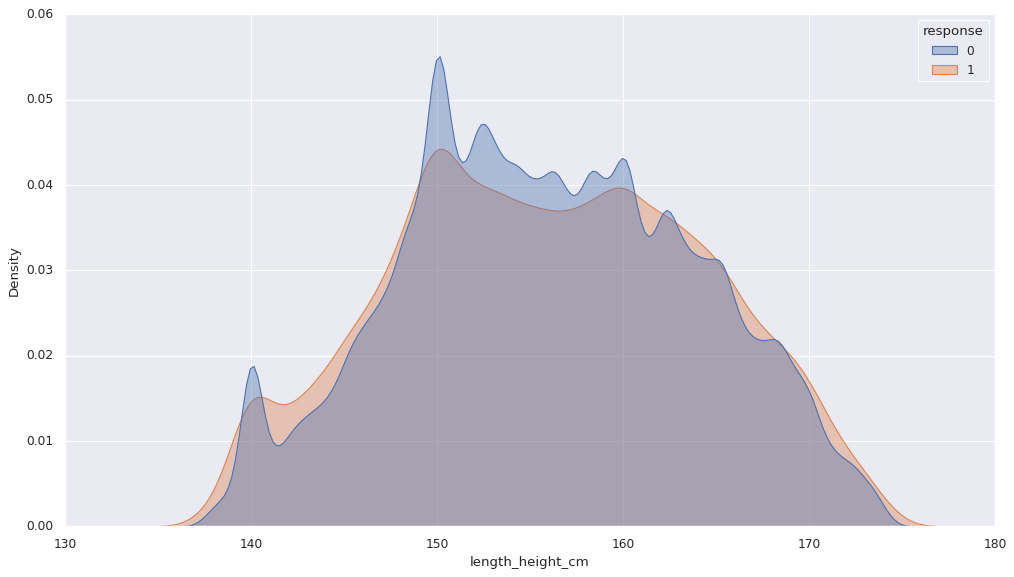

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(data=merged_df, x="length_height_cm", hue="response", shade = True, common_norm=False, alpha=0.4)


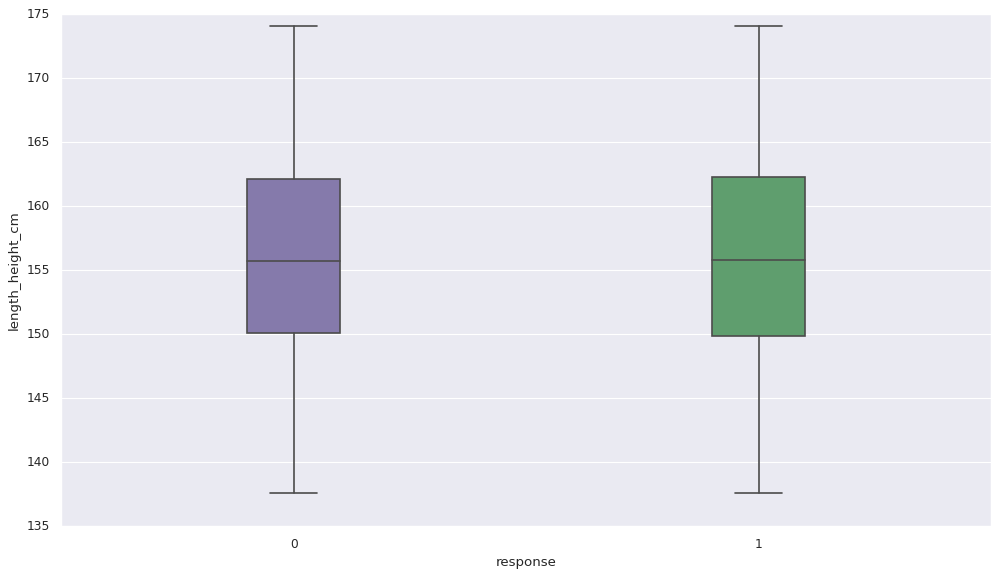

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.boxplot(data=merged_df, x="response",y= 'length_height_cm',showfliers=False, width = 0.2,palette=["m", "g"],)


### *Plot evincing the role of quality of salt in patient being diabetic or non-diabetic.*

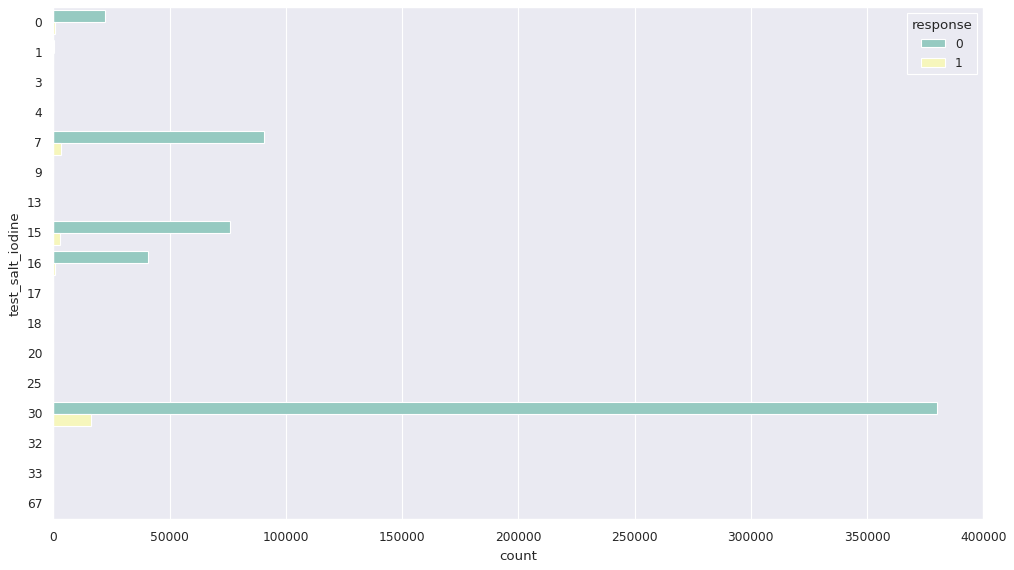

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})

sb.countplot(y="test_salt_iodine", hue="response",data=merged_df,palette="Set3")

### *Role of age in Diabetes.*

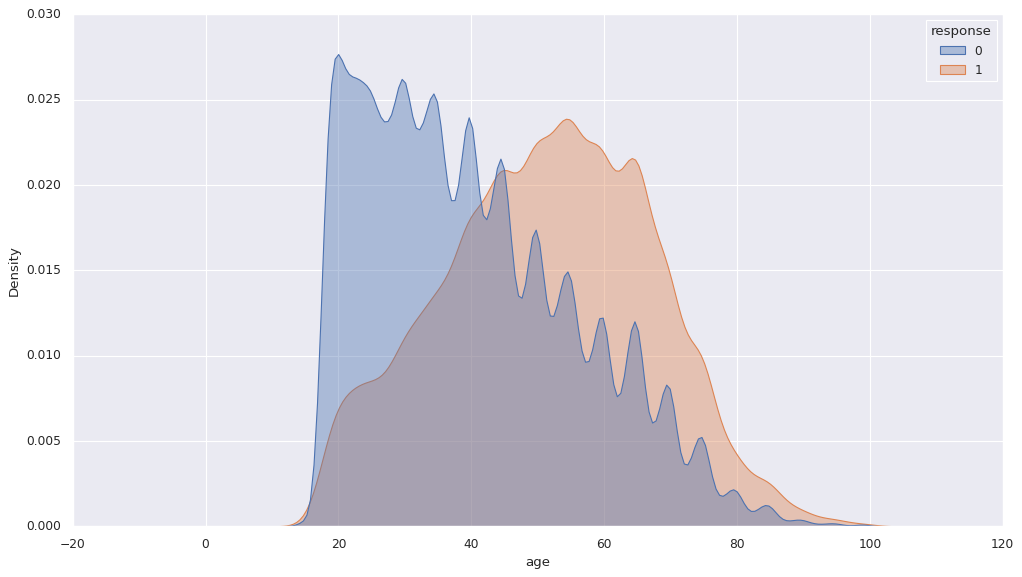

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(data=merged_df, x="age", hue="response", shade = True, common_norm=False, alpha=0.4)


### Age Vs Diabetes (Hist)

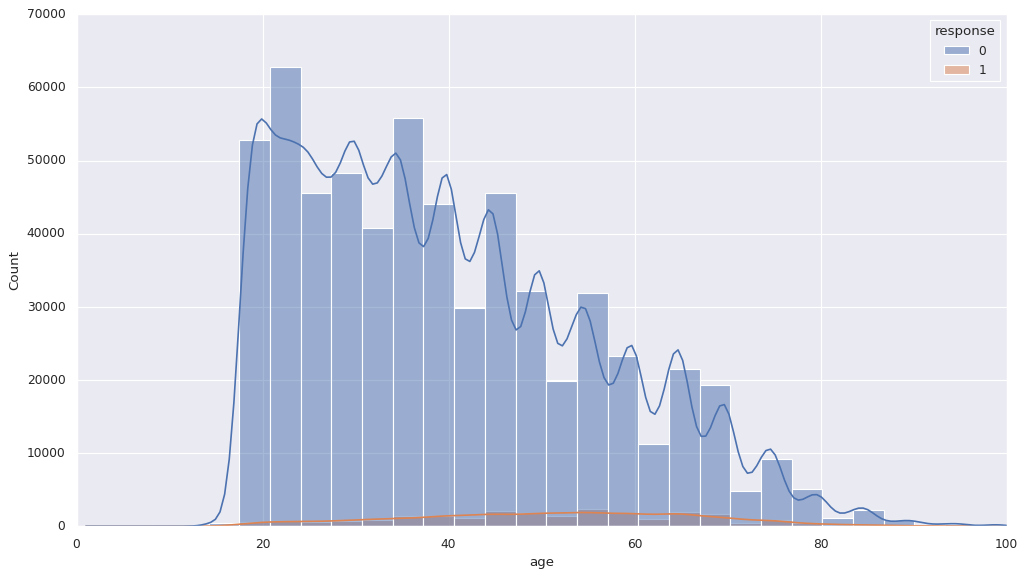

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})

sb.histplot(data=merged_df, x="age",hue = 'response', kde=True,bins=30,common_norm=True)

### *Role of Gender in Diabetes.*

Text(0.5, 1.0, 'Count_Plot [Male-0, Female-1]')

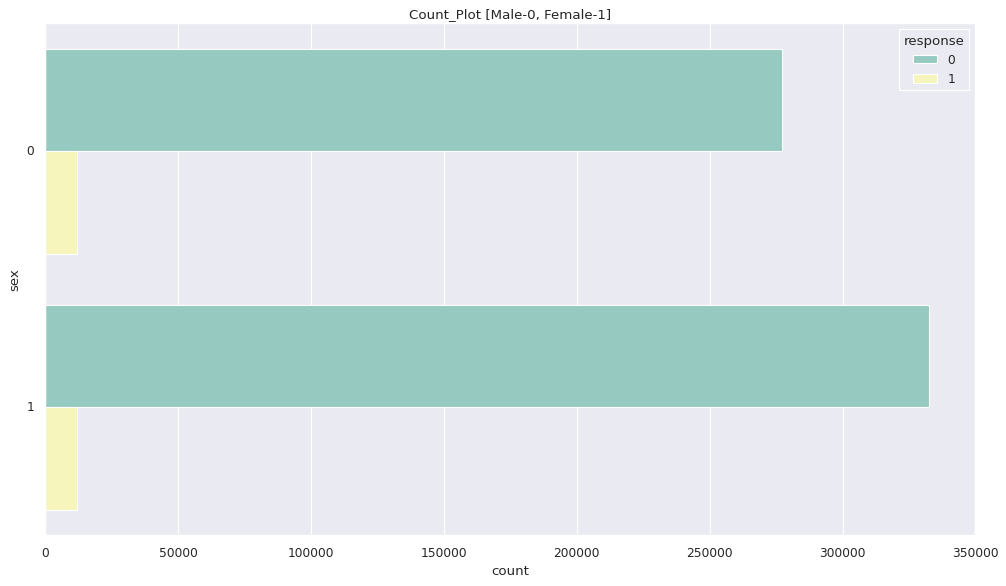

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.countplot(y="sex", hue="response",data=merged_df,palette="Set3")
plt.title('Count_Plot [Male-0, Female-1]')
# Male 0, Female 1

### *Haemoglobin Level for Diabetic and Non-Diabetic Patients.*

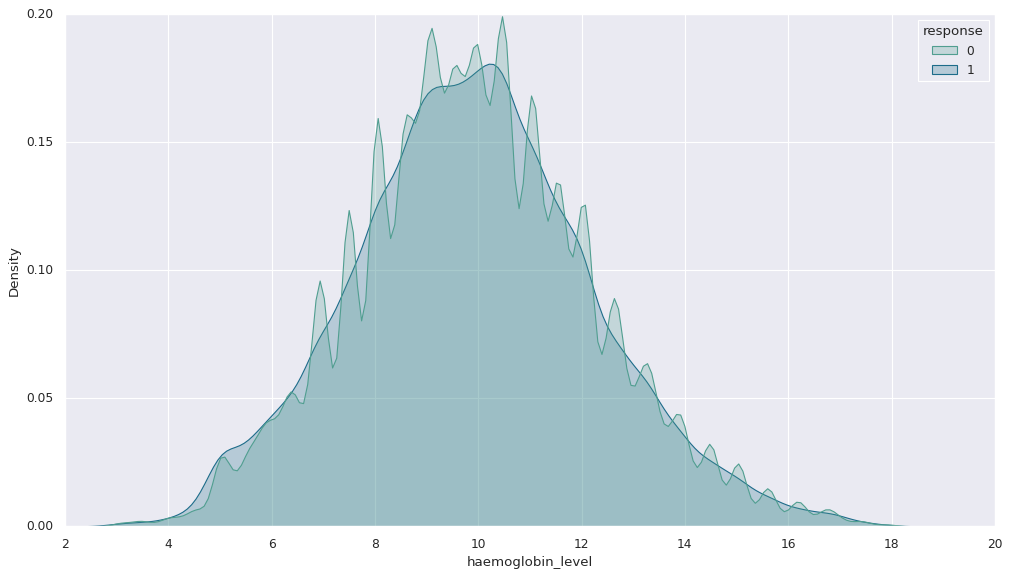

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(data=merged_df, x="haemoglobin_level", hue="response", shade = True, common_norm=False,palette="crest")


# sb.kdeplot(dataframe_UP_final['haemoglobin_level'].loc[dataframe_UP_final['response']==0], color="red", shade=True)
# sb.kdeplot(dataframe_UP_final['haemoglobin_level'].loc[dataframe_UP_final['response']==1], color="yellow", shade=True)

### Fasting Glucose Levels for Diabetic and Non-Diabetic Patients


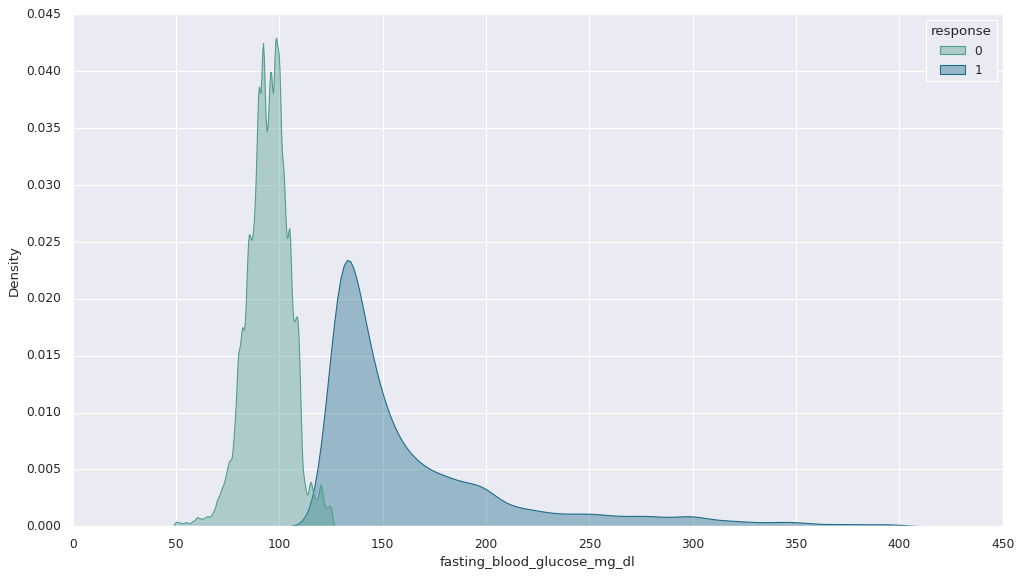

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(data=merged_df, x="fasting_blood_glucose_mg_dl", hue="response", shade = True, common_norm=False, alpha=0.4,palette="crest")


### *Systolic Levels for Diabetic and Non-Diabetic Patients.*

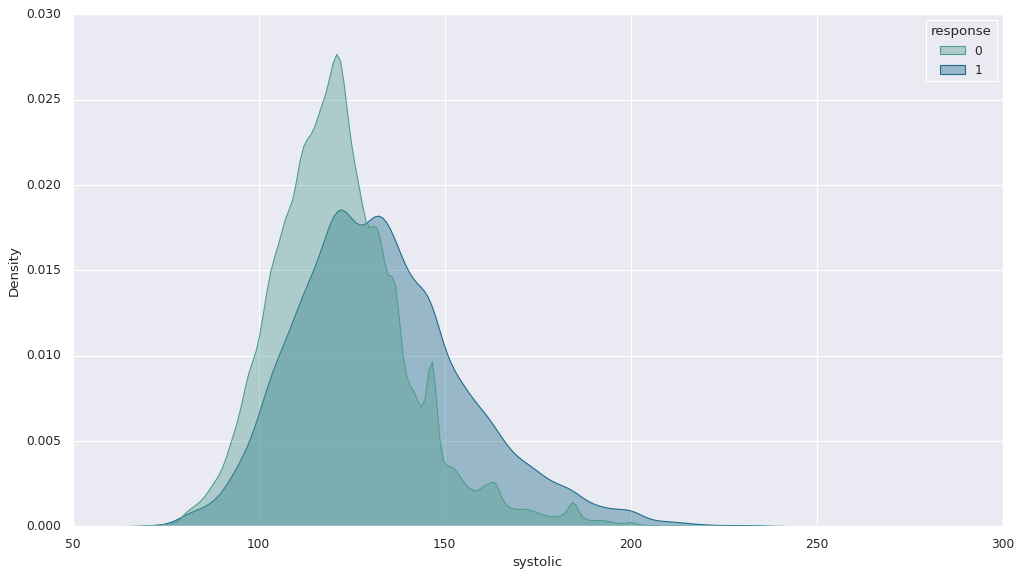

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(data=merged_df, x="systolic", hue="response", shade = True, common_norm=False, alpha=0.4,palette="crest")


### *Diastolic Levels for Diabetic and Non-Diabetic Patients.*

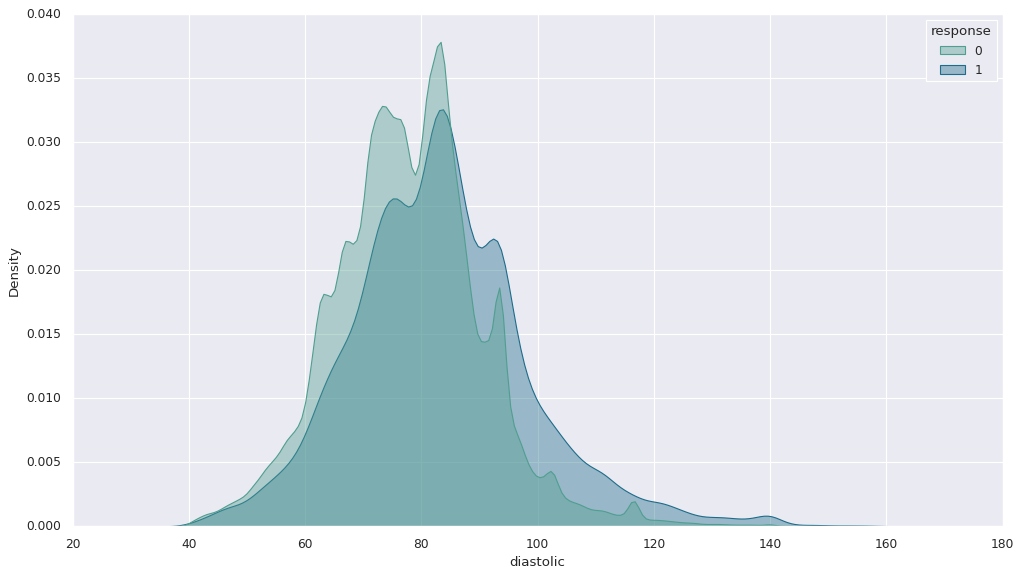

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(data=merged_df, x="diastolic", hue="response", shade = True, common_norm=False, alpha=0.4,palette="crest")


### *Pulse Levels for Diabetic and Non-Diabetic Patients.*

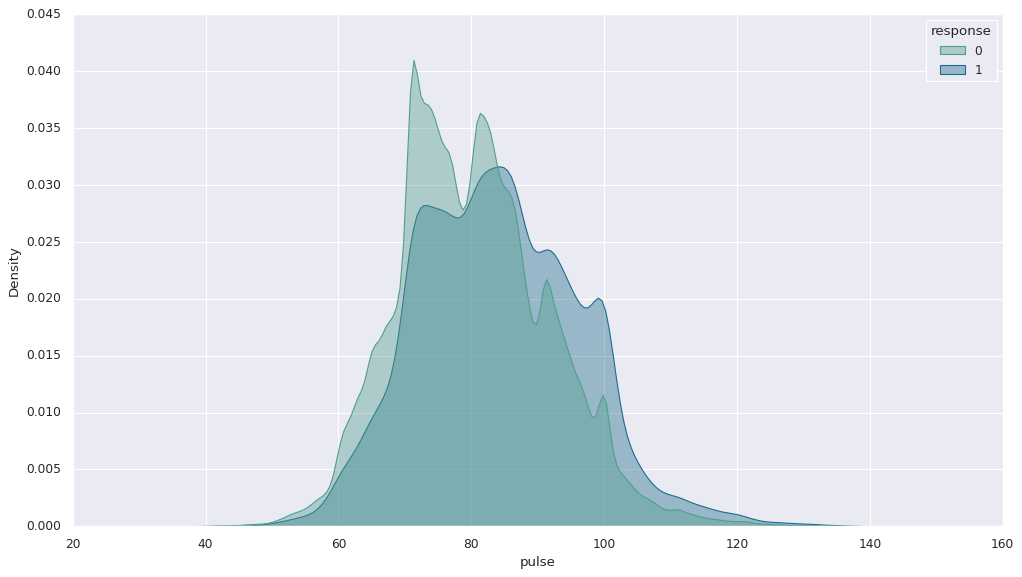

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})
sb.kdeplot(data=merged_df, x="pulse", hue="response", shade = True, common_norm=False, alpha=0.4,palette="crest")


### *Statewise Histogram*

In [ ]:
merged_df.loc[merged_df['state_code'] == 5, 'state_name'] = 'Uttarakhand' 
merged_df.loc[merged_df['state_code'] == 8, 'state_name'] = 'Rajasthan' 
merged_df.loc[merged_df['state_code'] == 9, 'state_name'] = 'Uttar Pradesh' 
merged_df.loc[merged_df['state_code'] == 10, 'state_name'] = 'Bihar' 
merged_df.loc[merged_df['state_code'] == 18, 'state_name'] = 'Assam' 
merged_df.loc[merged_df['state_code'] == 20, 'state_name'] = 'Jharkhand' 
merged_df.loc[merged_df['state_code'] == 21, 'state_name'] = 'Odisha' 
merged_df.loc[merged_df['state_code'] == 22, 'state_name'] = 'Chhattisgarh'
merged_df.loc[merged_df['state_code'] == 23, 'state_name'] = 'Madhya Pradesh'  

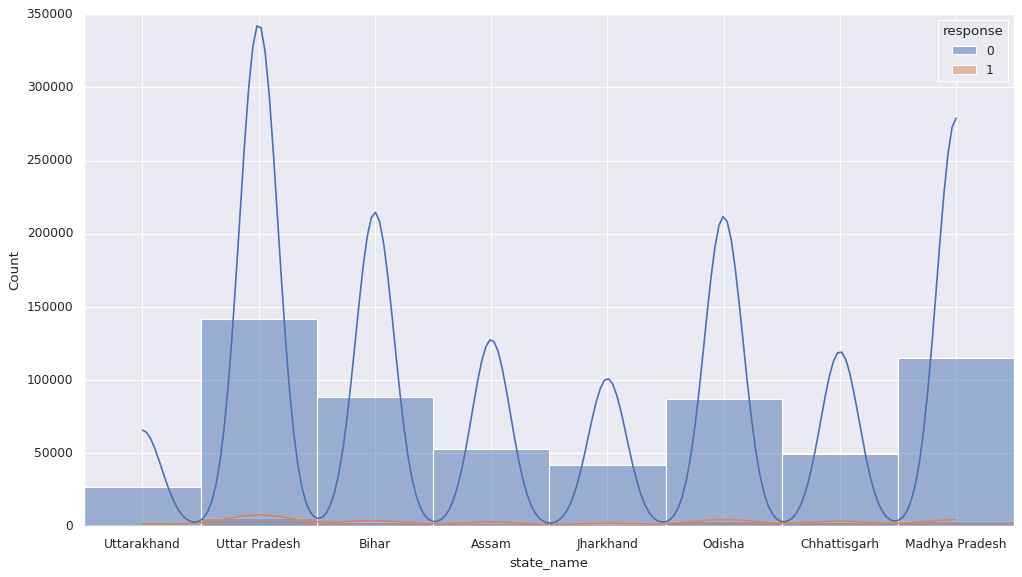

In [ ]:
sb.set_style("whitegrid")
sb.set(rc = {'figure.figsize':(15,8)})

sb.histplot(data=merged_df, x="state_name",hue = 'response', kde=True,bins=30,common_norm=True,color='lime')

# **MODEL TRAINING**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, average_precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE


df = pd.read_pickle('/content/drive/MyDrive/NEU/Semester 2/SML/Multi-Layer Perceptron/archive/merged')
df['response'] = np.where(df['fasting_blood_glucose_mg_dl'] > 125,1,0)


df_copy = df.copy()

pd.set_option('max_columns', 50)

df_copy = df_copy.dropna()
df_copy = df_copy.drop_duplicates()


'''Renaming the data column'''
df_copy = df_copy.rename({"response" : "is_Diabetic"},axis=1)

df_copy.drop(['age_code', 'fasting_blood_glucose_mg_dl'], axis = 1, inplace = True)


'''oversampling diabetoc data using SMOTE'''

pd.crosstab(index = df_copy["is_Diabetic"], columns = "Frequency")



col_list = list(df_copy.columns)
col_list.pop(-1)

smote = SMOTE(random_state=0)

X,y = smote.fit_resample(df_copy[col_list], df_copy[['is_Diabetic']])

df_oversampled = X
df_oversampled['is_Diabetic'] = y


'''Validating the result of the Oversampling'''
pd.crosstab(index = df_oversampled["is_Diabetic"], columns = "Frequency")





'''Splitting the oversampled data to Training and testing data'''

train_x, test_x, train_y, test_y = train_test_split(df_oversampled.iloc[:,:15], df_oversampled['is_Diabetic'], test_size=0.3, random_state=0)

'''Scaling the features'''
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)





'''User defined functions to display performance metrics of the Perceptron Object'''
def evaluate(y_true, y_pred):
    ac= accuracy_score(y_true, y_pred)
    cf = confusion_matrix(y_true, y_pred)
    return ac, cf

def display(y_true, y_pred, model):
    ac, cf = evaluate(y_true, y_pred)
    print("Model : ", model, "\n Accuracy Score : ", ac, "\n Confusion Matrix : ", cf, "\n Classification Report : \n", classification_report(y_true, y_pred))


'''Creating a Custom Scorer to add to the Grid Search Cross Validation in order to find the best parameters for the '''
diabetic = 1
non_diabetic = 0

custom_scorer = {'recall' : make_scorer(recall_score, pos_label = diabetic), 'precision' : make_scorer(average_precision_score, pos_label = diabetic)}

param_grid = {"activation" : ["logistic", "tanh", "relu"], "learning_rate" : ["invscaling", "adaptive"], "solver" : ['sgd', 'adam'], "hidden_layer_sizes" : range(1,7,1)}

gscv = GridSearchCV(MLPClassifier(max_iter = 10000, random_state= 0), param_grid, cv = 5, verbose = False,  scoring = custom_scorer, refit = 'recall')
gscv.fit(train_x, train_y)


'''Best parameters for MLP Agent from GridSearchCV'''

gscv.best_params_

'''{'activation': 'logistic',
 'hidden_layer_sizes': 5,
 'learning_rate': 'adaptive',
 'solver': 'sgd'}'''


'''Fitting the Machine Learning model on the data'''
mlp = MLPClassifier(max_iter = 1000, random_state= 0 , activation = "tanh", learning_rate= "adaptive", solver = "sgd", hidden_layer_sizes = 6)
mlp.fit(train_x, train_y)
train_y_pred = mlp.predict(train_x)
test_y_pred = mlp.predict(test_x)

'''Validating the results using the performance metrics'''
display(train_y, train_y_pred, 'MLP: Training after Hyperparameter Tuning')
display(test_y, test_y_pred, 'MLP: test after Hyperparameter Tuning')
